# Analysing chemistry space of the APOGEE RC catalogue 
### with t-SNE, UMAP, and PCA 

In [15]:
import numpy as np
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
import seaborn as sns
import os.path

from time import time
from sklearn import manifold, datasets

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import product

import obtain_data

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=16, usetex=True)

## Preparing the sample on which to run tSNE, PCA and UMAP

### The APOGEE DR16 RC sample
The [DR16 red-clump catalogue](https://www.sdss.org/dr16/data_access/value-added-catalogs/?vac_id=apogee-red-clump-(rc)-catalog) is a very clean selection of RC stars from APOGEE DR16. The first version of the catalogue dates back to DR11 and has since been continuously maintained & updated by Jo Bovy (Toronto).


In [2]:
import importlib
importlib.reload(obtain_data)

apo_rc = obtain_data.apogeedr16_rc()

16193 stars in your APOGEE DR16 sample all


### Prepare the input arrays for PCA, t-SNE, and umap...

... for all the samples used here. We use the functions built into `open_data.py`. 

In [3]:
# Decide on what to use as input for the dimensionality reduction code:
cn       = True    # only applicable for APOGEE (not enough stars with C/N measured for Bensby & HARPS)
feh      = True    # whether to include Fe/H as a dimension - currently not implemented for APOGEE!
norm     = "stdev" # other possible choices: "hogg2016" or None

# Define some useful names
data     = [apo_rc]
dataname = ["APOGEE DR16 RC"]
idcol    = ["APOGEE_ID"]
tname    = ["apogee_rc"]

Xlist, Xerrlist, Xnormlist = [], [], []

for ii in [0]:
    data[ii].get_ndimspace(cn=cn, norm=norm)
    X, Xerr, Xnorm = data[ii].X, data[ii].Xerr, data[ii].Xnorm
    Xlist.append(X); Xerrlist.append(Xerr); Xnormlist.append(Xnorm)

### Run umap, tsne and PCA for each of the samples in all possibly interesting configurations

The cell below runs the three algorithms for all the samples and saves the results as fits files: **IF YOU DON'T WANT TO RECOMPUTE EVERYTHING, JUST READ THOSE FILES!**

We explore the hyperparameter configurations suggested by these docs:
* https://opentsne.readthedocs.io/en/latest/parameters.html
* https://distill.pub/2016/misread-tsne/
* https://opentsne.readthedocs.io/en/latest/examples/03_preserving_global_structure/03_preserving_global_structure.html
* https://umap-learn.readthedocs.io/en/latest/parameters.html

In [4]:
# Set hyperparameters for all dimred methods:
components=2

# For tsne & umap:
metrics      = ["euclidean" ]# "cosine", "mahalanobis""mahalanobis" not working by default for sklearn.manifold.TSNE

## in particular for tsne:
perplexities   = [30, 40, 50, 60, 80, 100] #[5, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200] 
learning_rates = [10, 100] #[1, 10, 100, 500]
## in particular for umap:
n_neighbors  = [30, 40, 50, 60, 80, 100] # [5, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200]
min_dists    = [0.1, 0.25, 0.5]# [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

DON'T RUN THE CELL BELOW IF YOU DON'T NEED TO:) 
IT TAKES A WHILE TO RECOMPUTE ALL THE umap AND t-SNE MAPS

### For each sample, produce a set of plots showing the influence of the hyperparameters:

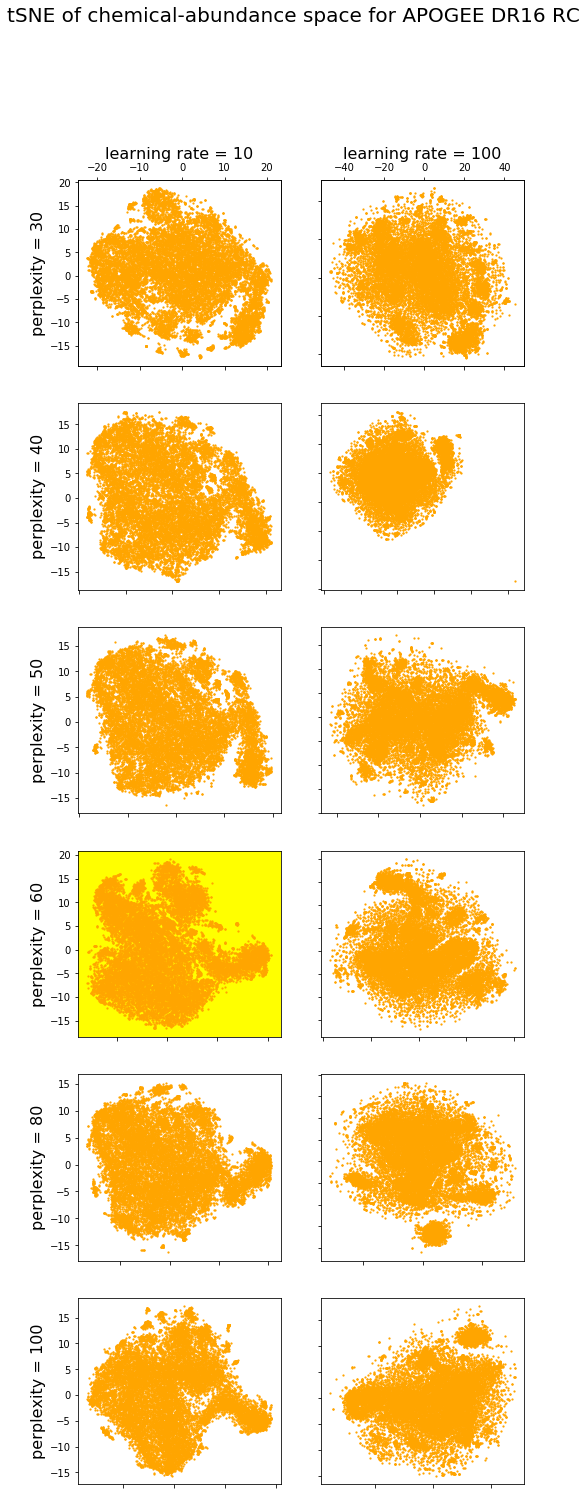

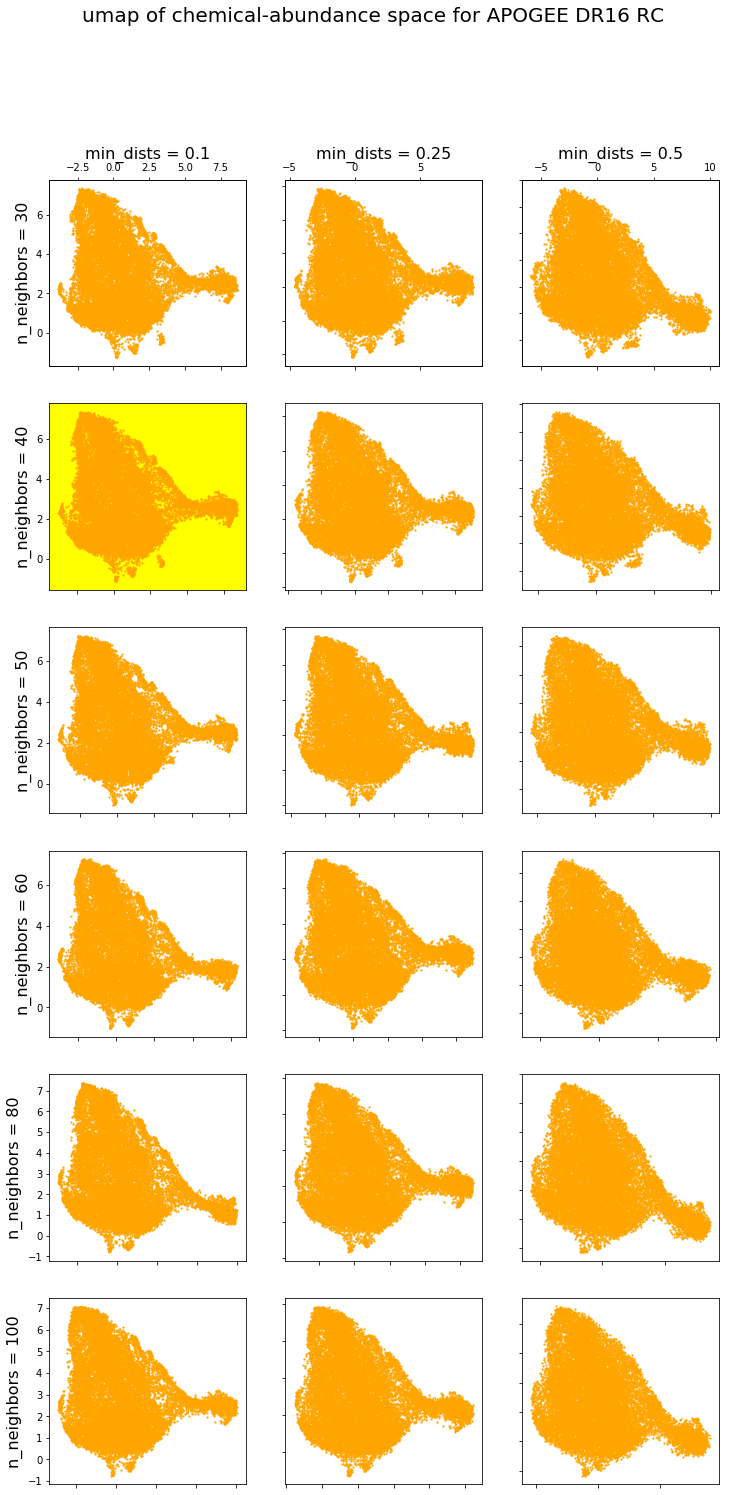

In [6]:
import matplotlib.gridspec as gridspec

algname  = ["tSNE", "umap"]
colors   = ["orange", "m", "r", "b", "k"]

metric = "euclidean"
## in particular for tsne:
perplexities   = [30, 40, 50, 60, 80, 100] #[5, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200] 
learning_rates = [10, 100] #[1, 10, 100, 500]
## in particular for umap:
n_neighbors  = [30, 40, 50, 60, 80, 100] # [5, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200]
min_dists    = [0.1, 0.25, 0.5]# [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

# define the optimal hyperparameter values by eye & colour the corresponding panels:
t_opt = [[ 60, 10],[ 20, 100],[ 60, 100],[ 20, 100],[ 20, 100] ]
u_opt = [[ 40, .1],[ 20, .1],[ 40, .1],[ 20, .1],[ 20, .1] ]

for ii in [0,1]:
    if ii == 0:
        # tsne
        xx = perplexities
        yy = learning_rates
        p_opt = t_opt
    else:
        # umap
        xx = n_neighbors
        yy = min_dists
        p_opt = u_opt
    for jj in [0]:
        f = plt.figure(figsize=(4*len(yy), 4*len(xx)))
        gs0 = gridspec.GridSpec(len(xx), len(yy))
        plt.suptitle(algname[ii]+" of chemical-abundance space for "+dataname[jj], fontsize=20)
        # Read dimred results:
        results = Table.read("../data/dimred_results/"+tname[jj]+"_dimred_hyperparametertest.fits")
        # Loop over each subplot:
        for kk, ll in product(range(len(xx)), range(len(yy))):
            ax = plt.Subplot(f, gs0[kk, ll])
            f.add_subplot(ax)
            # Get the relevant columns for the subplot:
            if ii == 0:
                colstring = algname[ii]+"_"+ metric+"_p"+str(xx[kk]) + "_lr"+str(yy[ll])
            else:
                colstring = algname[ii]+"_"+ metric+"_nn"+str(xx[kk]) + "_md"+str(yy[ll])
            # Plot those MoFos:
            scat = plt.scatter(results["X_"+colstring], results["Y_"+colstring], s=5, lw=0, c=colors[jj])
            # Beautify the axes:
            if xx[kk] == p_opt[jj][0] and yy[ll] == p_opt[jj][1]:
                ax.set_facecolor('yellow')
            if ll!=0:
                ax.yaxis.set_major_formatter(NullFormatter())
            else:
                if ii == 0:
                    ax.set_ylabel("perplexity = "+str(xx[kk]), fontsize=16)
                else:
                    ax.set_ylabel("n_neighbors = "+str(xx[kk]), fontsize=16)
            if kk==0:
                ax2 = ax.twiny()
                ax2.set_xlim(ax.get_xlim())
                if ii == 0:
                    ax2.set_xlabel("learning rate = "+str(yy[ll]), fontsize=16)
                else:
                    ax2.set_xlabel("min_dists = "+str(yy[ll]), fontsize=16)
            ax.xaxis.set_major_formatter(NullFormatter())
        plt.savefig("../im/"+tname[jj]+"_"+algname[ii]+"_"+metric+"-metric_parametertest.png", dpi=120)


### Now plotting each sample colour-coded by the input parameters (similar to A18, Fig. 2):

APOGEE DR16 RC sample


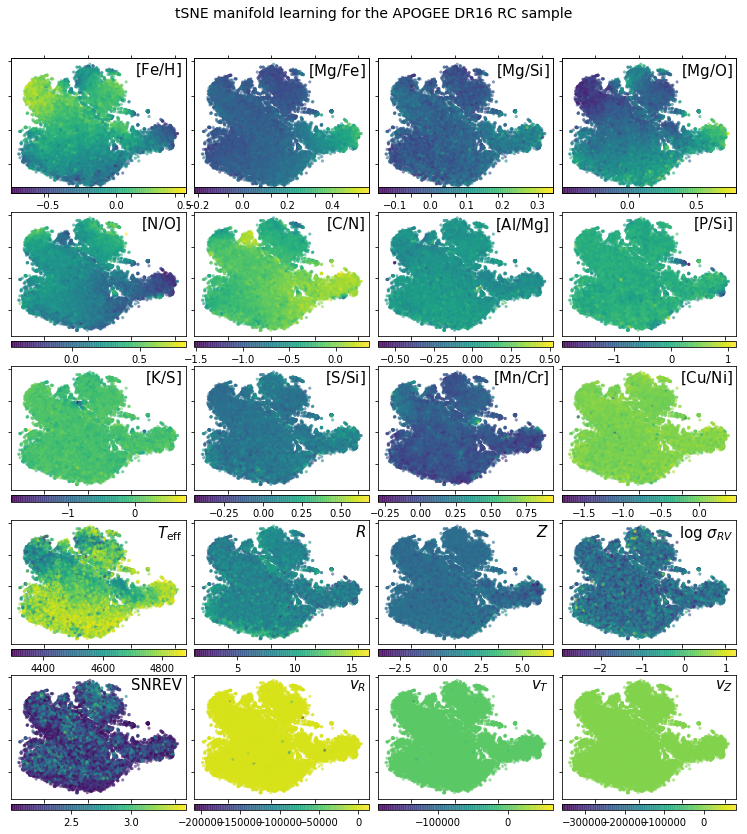

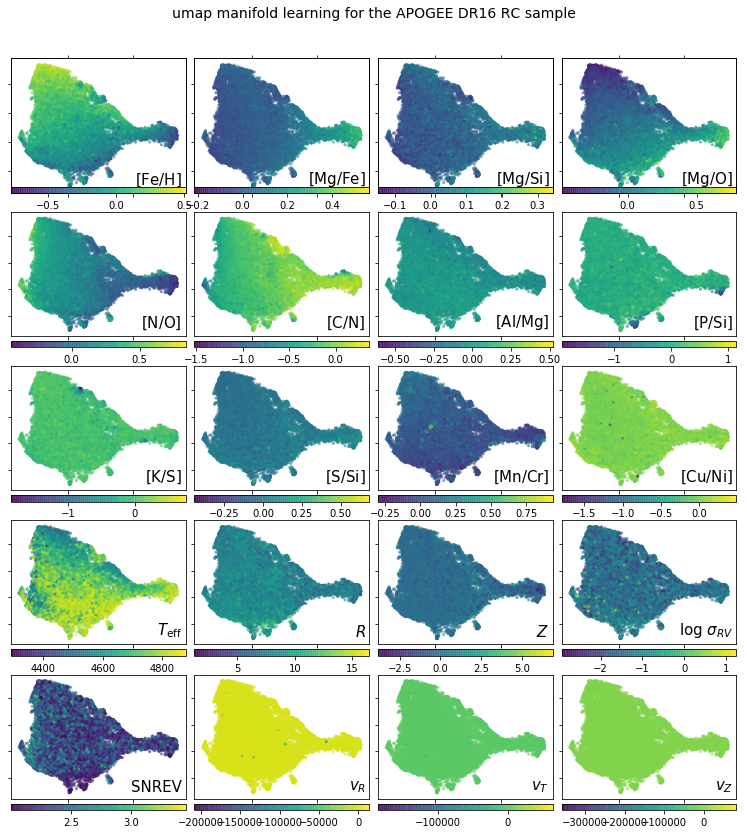

In [7]:
algs   = ["tSNE", "umap"]
metric = "euclidean"
titlenames = ["APOGEE DR16 RC sample"]
sizes  = [10]

for ss in range(len(data)):
    print(titlenames[ss])
    data[ss].get_umap_tsne_colours(p=60, lr=10, nn=40, md=.1)
    for aa in algs:
        f = plt.figure(figsize=(12, 12))
        plt.suptitle(aa + " manifold learning for the " + titlenames[ss], fontsize=14)
        import matplotlib.gridspec as gridspec
        gs0 = gridspec.GridSpec(5, 4)
        gs0.update(left=0.08, bottom=0.05, right=0.92, top=0.92,
                   wspace=0.05, hspace=0.14)
        # decide what to plot
        if aa == "tSNE":
            x, y = data[ss].Xt, data[ss].Yt
        elif aa == "umap":
            x, y = data[ss].Xu, data[ss].Yu
        for ii in range(5):
            for jj in range(4):
                ax = plt.Subplot(f, gs0[ii, jj])
                if ss == 1 and ((ii==0 and jj>2) or (ii==1 and jj==0)):
                    pass # No plots involving oxygen for the subgiants
                else:
                    f.add_subplot(ax)
                scat = plt.scatter(x, y, 
                                   c=data[ss].colors[4*ii+jj], norm=None, lw=0., s=sizes[ss],
                                   cmap=plt.cm.viridis, alpha=0.6)
                if jj!=0:
                    ax.yaxis.set_major_formatter(NullFormatter())
                if ii==0:
                    ax2 = ax.twiny()
                    ax2.set_xlim(ax.get_xlim())
                    ax2.xaxis.set_major_formatter(NullFormatter())
                ax.xaxis.set_major_formatter(NullFormatter())
                ax.yaxis.set_major_formatter(NullFormatter())
                divider = make_axes_locatable(ax)
                cax = divider.new_vertical(size="5%", pad=0.07, pack_start=True)
                f.add_axes(cax)
                if aa == "tSNE":
                    ax.text(.98, .98, data[ss].titles[4*ii+jj], horizontalalignment='right',
                            verticalalignment='top', transform=ax.transAxes, fontsize=15)
                else:
                    ax.text(.98, .04, data[ss].titles[4*ii+jj], horizontalalignment='right',
                            verticalalignment='bottom', transform=ax.transAxes, fontsize=15)
                f.colorbar(scat, cax=cax, orientation="horizontal")
        plt.axis('tight')
        plt.savefig("../im/"+tname[ss]+"_"+aa+"_coloured.png", dpi=200)


APOGEE DR16 RC sample


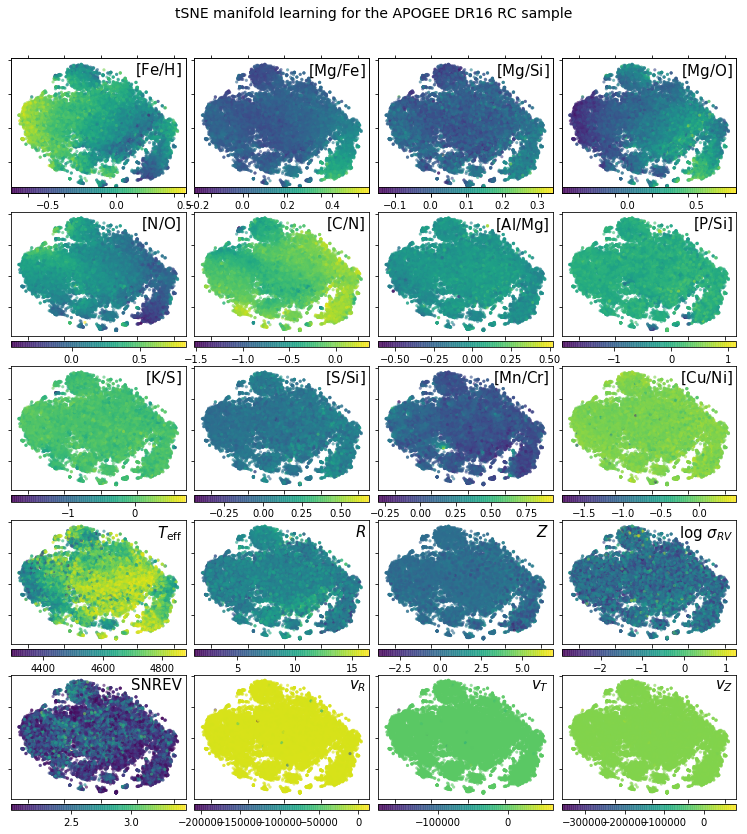

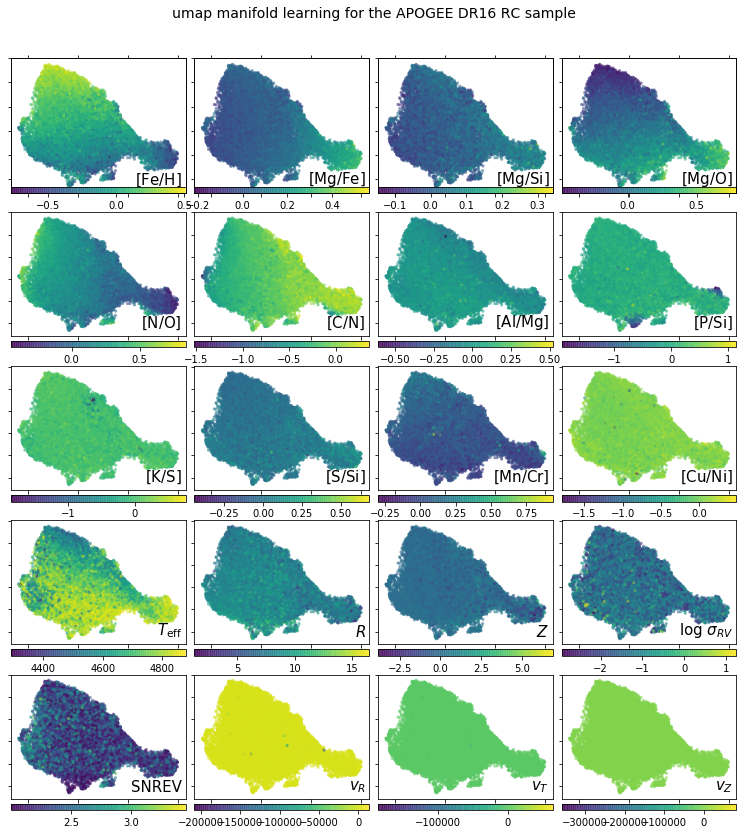

In [9]:
algs   = ["tSNE", "umap"]
metric = "euclidean"
titlenames = ["APOGEE DR16 RC sample"]
sizes  = [10]

a=30
b=10
c=30
d=0.5

for ss in range(len(data)):
    print(titlenames[ss])
    data[ss].get_umap_tsne_colours(p=a, lr=b, nn=c, md=d)
    for aa in algs:
        f = plt.figure(figsize=(12, 12))
        plt.suptitle(aa + " manifold learning for the " + titlenames[ss], fontsize=14)
        import matplotlib.gridspec as gridspec
        gs0 = gridspec.GridSpec(5, 4)
        gs0.update(left=0.08, bottom=0.05, right=0.92, top=0.92,
                   wspace=0.05, hspace=0.14)
        # decide what to plot
        if aa == "tSNE":
            x, y = data[ss].Xt, data[ss].Yt
        elif aa == "umap":
            x, y = data[ss].Xu, data[ss].Yu
        for ii in range(5):
            for jj in range(4):
                ax = plt.Subplot(f, gs0[ii, jj])
                if ss == 1 and ((ii==0 and jj>2) or (ii==1 and jj==0)):
                    pass # No plots involving oxygen for the subgiants
                else:
                    f.add_subplot(ax)
                scat = plt.scatter(x, y, 
                                   c=data[ss].colors[4*ii+jj], norm=None, lw=0., s=sizes[ss],
                                   cmap=plt.cm.viridis, alpha=0.6)
                if jj!=0:
                    ax.yaxis.set_major_formatter(NullFormatter())
                if ii==0:
                    ax2 = ax.twiny()
                    ax2.set_xlim(ax.get_xlim())
                    ax2.xaxis.set_major_formatter(NullFormatter())
                ax.xaxis.set_major_formatter(NullFormatter())
                ax.yaxis.set_major_formatter(NullFormatter())
                divider = make_axes_locatable(ax)
                cax = divider.new_vertical(size="5%", pad=0.07, pack_start=True)
                f.add_axes(cax)
                if aa == "tSNE":
                    ax.text(.98, .98, data[ss].titles[4*ii+jj], horizontalalignment='right',
                            verticalalignment='top', transform=ax.transAxes, fontsize=15)
                else:
                    ax.text(.98, .04, data[ss].titles[4*ii+jj], horizontalalignment='right',
                            verticalalignment='bottom', transform=ax.transAxes, fontsize=15)
                f.colorbar(scat, cax=cax, orientation="horizontal")
        plt.axis('tight')
        if aa == "tSNE":
            plt.savefig("../im/"+tname[ss]+"_"+aa+"_"+"p"+str(a)+"lr"+str(b)+"colored.png", dpi=200)
        else:
            plt.savefig("../im/"+tname[ss]+"_"+aa+"_"+"nn"+str(c)+"md"+str(d)+"colored.png", dpi=200)

## How compact are physical clusters in the umap/t-SNE sapce?

Read the open-cluster member file:

In [18]:
memberlist = Table.read("../data/rc_clustermembers.txt", format="ascii")
memberlist

<Table length=72>
        ID          CLUSTER   CG_PROB
      str18          str10    float64
------------------ ---------- -------
2M00541152+8515231    NGC 188     1.0
2M00543664+8501152    NGC 188     1.0
2M00571844+8510288    NGC 188     1.0
2M00581691+8540183    NGC 188     1.0
2M06070155+2401470   NGC 2158     1.0
2M06071764+2410276   NGC 2158     1.0
2M06071913+2400148   NGC 2158     0.9
2M06072443+2400524   NGC 2158     1.0
2M06072907+2402151   NGC 2158     1.0
2M06073636+2405001   NGC 2158     1.0
               ...        ...     ...
2M23564304+5650477   NGC 7789     1.0
2M23565053+5649208   NGC 7789     1.0
2M23570895+5648504   NGC 7789     1.0
2M23571728+5645333   NGC 7789     1.0
2M23571847+5650271   NGC 7789     1.0
2M23573563+5640000   NGC 7789     1.0
2M06353172+0924287 Trumpler 5     1.0
2M06364193+0928117 Trumpler 5     1.0
2M06372817+0943118 Trumpler 5     1.0
2M06374091+0934530 Trumpler 5     1.0

In [40]:
xmatch = astropy.table.join(memberlist, results, keys=None, join_type='inner', 
                            uniq_col_name='{col_name}_{table_name}', table_names=['1', '2'], 
                            metadata_conflicts='warn')
list(np.unique(xmatch["CLUSTER"]))

['NGC 188', 'NGC 2204', 'NGC 2682', 'NGC 6791', 'NGC 6819', 'Trumpler 5']

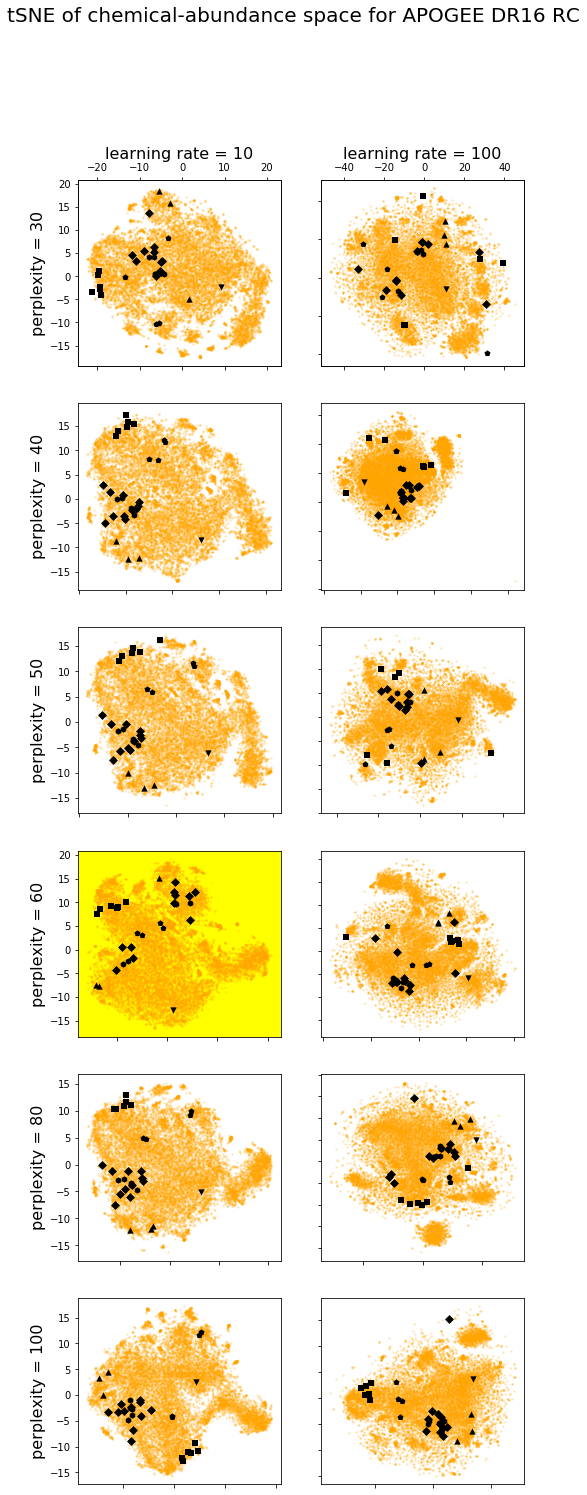

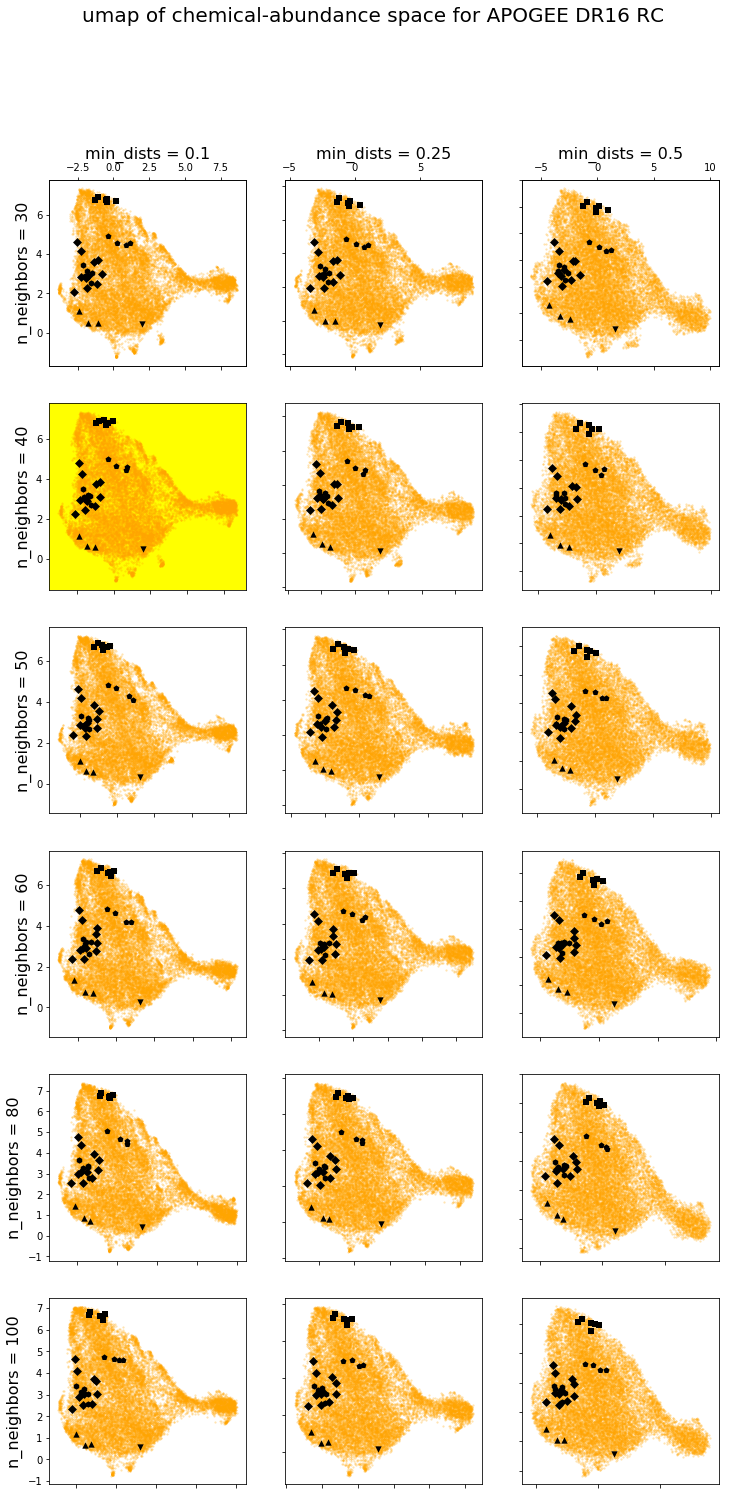

In [46]:
clusterlist = list(np.unique(xmatch["CLUSTER"]))
symbols     = ["p", "^", "h", "s", "D", "v", "H", "<",  "*","+", ">", "x"]


algname  = ["tSNE", "umap"]
colors   = ["orange", "m", "r", "b", "k"]

metric = "euclidean"
## in particular for tsne:
perplexities   = [30, 40, 50, 60, 80, 100] #[5, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200] 
learning_rates = [10, 100] #[1, 10, 100, 500]
## in particular for umap:
n_neighbors  = [30, 40, 50, 60, 80, 100] # [5, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200]
min_dists    = [0.1, 0.25, 0.5]# [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

# define the optimal hyperparameter values by eye & colour the corresponding panels:
t_opt = [[ 60, 10],[ 20, 100],[ 60, 100],[ 20, 100],[ 20, 100] ]
u_opt = [[ 40, .1],[ 20, .1],[ 40, .1],[ 20, .1],[ 20, .1] ]

for ii in [0,1]:
    if ii == 0:
        # tsne
        xx = perplexities
        yy = learning_rates
        p_opt = t_opt
    else:
        # umap
        xx = n_neighbors
        yy = min_dists
        p_opt = u_opt

    f = plt.figure(figsize=(4*len(yy), 4*len(xx)))
    gs0 = gridspec.GridSpec(len(xx), len(yy))
    plt.suptitle(algname[ii]+" of chemical-abundance space for "+dataname[jj], fontsize=20)
    # Loop over each subplot:
    for kk, ll in product(range(len(xx)), range(len(yy))):
        ax = plt.Subplot(f, gs0[kk, ll])
        f.add_subplot(ax)
        # Get the relevant columns for the subplot:
        if ii == 0:
            colstring = algname[ii]+"_"+ metric+"_p"+str(xx[kk]) + "_lr"+str(yy[ll])
        else:
            colstring = algname[ii]+"_"+ metric+"_nn"+str(xx[kk]) + "_md"+str(yy[ll])
        # Plot those MoFos:
        scat = plt.scatter(results["X_"+colstring], results["Y_"+colstring], s=5, lw=0, alpha=0.3, c=colors[jj])
        # Overplot cluster members
        for cc in np.arange(len(clusterlist)):
            members_cc = xmatch[ xmatch["CLUSTER"]==clusterlist[cc] ]
            for mm in members_cc["ID"]:
                plt.scatter(results[(results["ID"]==mm)]["X_"+colstring], 
                            results[(results["ID"]==mm)]["Y_"+colstring], s=40, lw=0, 
                            c="k", marker=symbols[cc])
        # Beautify the axes:
        if xx[kk] == p_opt[jj][0] and yy[ll] == p_opt[jj][1]:
            ax.set_facecolor('yellow')
        if ll!=0:
            ax.yaxis.set_major_formatter(NullFormatter())
        else:
            if ii == 0:
                ax.set_ylabel("perplexity = "+str(xx[kk]), fontsize=16)
            else:
                ax.set_ylabel("n_neighbors = "+str(xx[kk]), fontsize=16)
        if kk==0:
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            if ii == 0:
                ax2.set_xlabel("learning rate = "+str(yy[ll]), fontsize=16)
            else:
                ax2.set_xlabel("min_dists = "+str(yy[ll]), fontsize=16)
        ax.xaxis.set_major_formatter(NullFormatter())
    plt.savefig("../im/"+tname[jj]+"_"+algname[ii]+"_"+metric+"-metric_parametertest_withclusters.png", dpi=120)


### Making a big plot colour-coded by [Fe/H], overplotting RC cluster members:

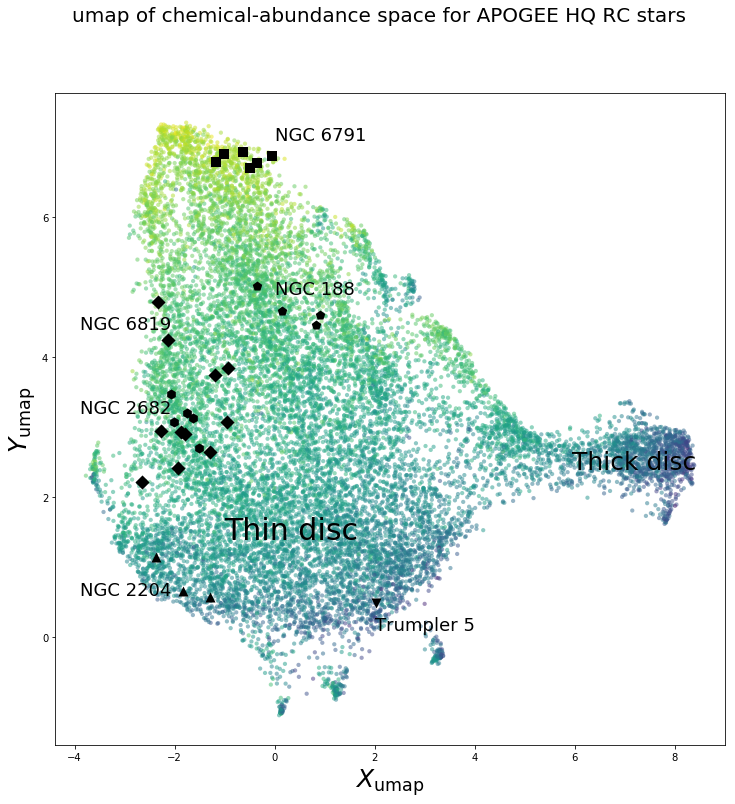

In [75]:
colstring = "umap_euclidean_nn40_md0.1"

f = plt.figure(figsize=(12,12))

plt.suptitle("umap of chemical-abundance space for APOGEE HQ RC stars", fontsize=20)            # Plot those MoFos:
scat = plt.scatter(results["X_"+colstring], results["Y_"+colstring], s=18, lw=0, alpha=0.5, 
                   c=data[0].data["FE_H"], label="APOGEE RC sample")
# Overplot cluster members
for cc in np.arange(len(clusterlist)):
    members_cc = xmatch[ xmatch["CLUSTER"]==clusterlist[cc] ]
    for mm in members_cc["ID"]:
        plt.scatter(results[(results["ID"]==mm)]["X_"+colstring], 
                    results[(results["ID"]==mm)]["Y_"+colstring], s=100, lw=0, 
                    c="k", marker=symbols[cc], label=clusterlist[cc])
plt.text(0,7.1, "NGC 6791", fontsize=18)
plt.text(0,4.9, "NGC 188", fontsize=18)
plt.text(-3.9,.6, "NGC 2204", fontsize=18)
plt.text(-3.9,4.4, "NGC 6819", fontsize=18)
plt.text(-3.9,3.2, "NGC 2682", fontsize=18)
plt.text(2,.1, "Trumpler 5", fontsize=18)
  
plt.text(5.95,2.4, "Thick disc", fontsize=25)
plt.text(-1,1.4, "Thin disc", fontsize=30)
plt.xlabel(r"$X_{\rm umap}$", fontsize=25)
plt.ylabel(r"$Y_{\rm umap}$", fontsize=25)
plt.savefig("../im/umap_apogeerc_withclustermembers.png", dpi=120)